_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: Stephan Amann, David Stefan Kleindiek, Hannah Blaurock

# Coding Lab 1

- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-04-29 19:20:04CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.24.0

sklearn: 1.4.2

matplotlib: 3.8.4
pandas    : 2.2.2
scipy     : 1.13.0
numpy     : 1.26.4

Watermark: 2.4.3



In [3]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [4]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [5]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [6]:
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    y = x.apply(
        lambda col: signal.sosfiltfilt(  # apply the filter to all columns
            signal.butter(  # apply the filter to a column
                order,
                [low / (fs / 2), high / (fs / 2)],  # frequency thresholds (normalized)
                btype="band",  # filter type
                analog=False,
                output="sos",  # second-order sections
            ),
            col,
        )
    )

    return y

In [7]:
xf = filter_signal(x, fs, 300, 3000, order=5)

# Filter: Butterworth with bandwidth 300-6000 used by
# Yael D, Bar-Gad I. Filter based phase distortions in extracellular spikes. PLoS One. 2017 Mar 30;12(3):e0174790. doi: 10.1371/journal.pone.0174790
# But: 3000 HZ seems to be more reasonable in our case as it trims down the signal a little more
# Downside of larger trim: the PCA becomes a little denser

In [8]:
xf.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,-1.220593e-05,-9.599631e-07,-1.010151e-05,-1.920727e-05
std,4.408996e+01,4.326072e+01,4.841183e+01,4.342450e+01
min,-7.673553e+02,-6.802938e+02,-1.002850e+03,-7.041062e+02
25%,-2.237533e+01,-2.349494e+01,-2.367490e+01,-2.275217e+01
50%,1.316390e+00,1.280631e+00,1.512672e+00,1.407609e+00
75%,2.489541e+01,2.581631e+01,2.653003e+01,2.528102e+01
max,3.557988e+02,3.455039e+02,5.338312e+02,4.125817e+02


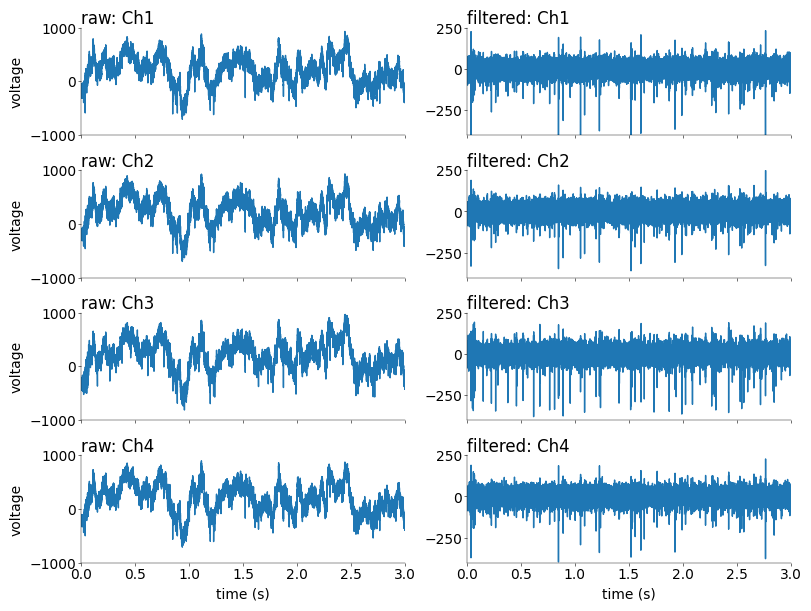

In [9]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -----------------------------------------------------------------
# Plot raw and filtered signal segments for all 4 channels (0.5 pt)
# -----------------------------------------------------------------

for i, m in enumerate(mosaic):
    raw = m[0]
    filtered = m[1]

    # plot colum i of the raw signal
    ax[raw].plot(x.index * dt, x.iloc[:, i])

    # plot column i of the filtered signal
    ax[filtered].plot(x.index * dt, xf.iloc[:, i])

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim(0, 3)  # (1.0515, 1.0535)
    ax[filtered].set_ylim((-400, 250))

    ax[raw].set_ylabel("voltage")
    ax[filtered].set_title(m[1], loc="left")

    ax[raw].set_title(m[0], loc="left")

    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. **Plot the threshold**. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [10]:
def remove_close_timestamps(timestamps: list, lockout: int) -> list:
    """Use list comprehension to filter out timestamps with lockout time difference

    Parameters
    ----------

    timestamps: list
        all indicies of detected signals, ordered.

    lockout: int
        The refractory time interval

    Returns
    -------

    timestamps: list
        all indicies of spikes that are not within the refractory period next to eachother

    """
    timestamps = [
        timestamps[i]
        for i in range(len(timestamps))
        if i == 0 or timestamps[i] - timestamps[i - 1] >= lockout
    ]
    return timestamps


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """

    # -----------------------------------------------------------------------
    # compute the robust s.d. (0.5 pts) and calculate the threshold (0.5 pts)
    # -----------------------------------------------------------------------

    # Caclulate individual sigma and threshold (for each channel)
    sigma_hat = np.apply_along_axis(
        lambda col: np.median(np.abs(col - np.mean(col))) / 0.6745, axis=0, arr=x
    )
    thresholds = -N * sigma_hat
    print("thresholds: Ch1 = {}; Ch2 = {}; Ch3 = {}; Ch4 = {}".format(*thresholds))

    # -------------------------------
    # find all local minima (1.5 pts)
    # -------------------------------

    minima = []
    for i in range(4):
        local_minima = signal.find_peaks(
            -x[:, i],  # negative because we want to find minima, not peaks
            height=-thresholds[i],
            distance=lockout,  # peaks within this distance are merged into one peak
            prominence=0,  # prominence != thershold - just difference to lowest contour line; but we need it to get left and right base (
            # width=1,  # minimum width of a peak is 1, but we get the width of each peak in return and thus can do t
        )
        minima.append(local_minima)

    # we now have a list of dicitionaries in mininma.
    # each dictionary contains the values of the inidicies (as an array, its the first entry of the dict),
    # the prominences (how far the peak is away from its lowest contour line),
    # and the left and right start of the peak (used to calc the time diff)

    # concatenate all peak index arrays in minima to one array to obtain all indicies of peaks
    s = np.concatenate([np.array(x[0]) for x in minima])

    # If we want the respective channel as well, we can do this instead (according to chat gpt, hasn't been tested yet)
    # tuples_list = [(value, idx) for idx, arr in enumerate(arrays) for value in arr]

    # Is t the timepoint at which the spikes occoured or the duration of each spike??
    # If it is the first we can just do:
    # t = (s / fs) * 1000 #transform the inidicies in s to ms

    # If its not we do this instead:
    # Calculate the differences between the respective left and right base arrays to get the spike duration
    t = [x[1]["right_bases"] - x[1]["left_bases"] for x in minima]
    t = [value for arr in t for value in arr]  # t is in Hertz, not ms
    scaled_t = [
        value / fs for value in t
    ]  # now t contains the duration of each peak in ms
    # Convert the list of differences to an ndarray
    scaled_t = np.array(scaled_t)

    return s, scaled_t, thresholds


xfc = xf.to_numpy().copy()
s, t, thresholds = detect_spikes(xfc, fs=fs, N=7)

thresholds: Ch1 = -245.55014803301628; Ch2 = -256.1638685801312; Ch3 = -260.82715629161754; Ch4 = -249.61189406451484


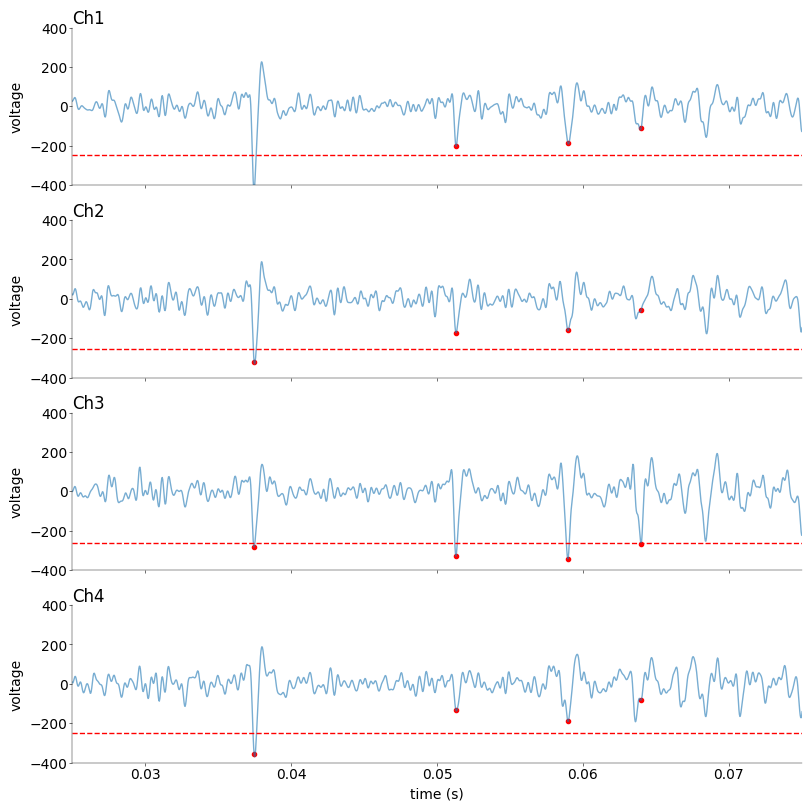

In [11]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# --------------------------------------------
# plot threshold and detected spikes (0.5 pts)
# --------------------------------------------

# manipluate s a bit: only take one index per peak - first sort s and then remove close index values
# Note: short_s is no longer aligned with t or with the respective channels
sorted_s = list.sort(list(s))
short_s = remove_close_timestamps(s, 10)
scaled_s = [value / fs for value in short_s]  # scle to match ms on x axis

for i, col in enumerate(cols):
    # extract all row indices (first value) of s with column index i (second value)
    # spike_indices = np.array([row[0] for row in s if row[1] == i])

    # plot signal
    ax[col].plot(x.index * dt, xf.iloc[:, i], alpha=0.6)

    # plot xf value as point at spike index
    # ax[col].scatter(
    #     spike_indices / fs, xf.iloc[spike_indices, i], color="r", label="spike"
    # )
    ax[col].scatter(scaled_s, xf.iloc[short_s, i], color="r", label="spike")

    # plot threshold as horizontal line
    ax[col].axhline(y=thresholds[i], color="r", linestyle="--", label="threshold")

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

The detected spikes are relatively well aligned with the peaks. Slight alterations might result from the fact, that only one timepoint per spike is accepted, all other are rejected. Thus the point representing the spike might result from another channel and thus might not be at the very peak of the spike in some of the channels. It will however be always the lowest point of the spike in one channel. 

Not that, just like on the slides on the lecture, all spikes regardless of the channel, are marked. This is due to the fact that even if a spike is just detected in one channel, the electromagnetic field will extend to the other channels as well. To compare the respective waveforms and extract the various features in the PCA it is, from our understanding, neccessary to keep all waveforms from all spikes, even if the spike wasn't detected in all 4 channels.

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [12]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times othrdf the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """

    # insert your code here

    # ------------------------------
    # extract spike waveforms (1 pt)
    # ------------------------------

    # for each index i in s extract the values x[i-10:i+20, :] and store them in w using broadcasting.
    w = np.array([x[i - 10 : i + 20, :] for i in s])
    print("w.shape: {}".format(w.shape))

    return w


waveforms = extract_waveforms(xf.to_numpy(), s)

w.shape: (30483, 30, 4)


Plot first 100 spike waveforms

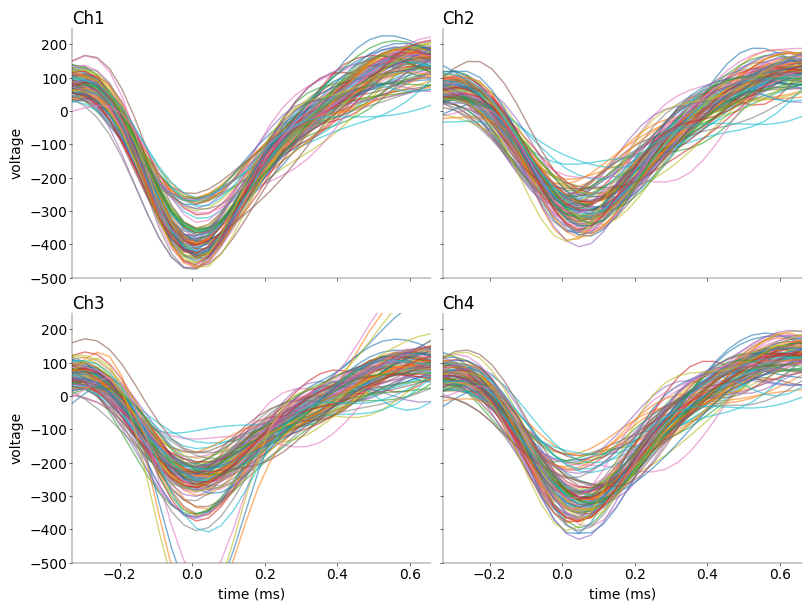

In [13]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------
# plot first 100 spikes (0.5 pts)
# -------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    # plot 100 times the 30 samples from channel i -> waveforms[:100, :, i]
    for j in range(100):  # TODO for-loop is ugly
        ax[col].plot(np.linspace(-0.33, 0.66, 30), waveforms[j, :, i], alpha=0.6)

    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

Answers to the questions: There are some small waves, but that is because we didn't plot only the spikes for the respective channels but the waveforms of all spike occourences, regardless of the channel. This doesn't reflect in the largest waveforms plot. You can see some waveforms that are probably artifacts, as they stay suspiciously long in a low frequency and don't show the classical curve.

Plot largest 100 spike waveforms

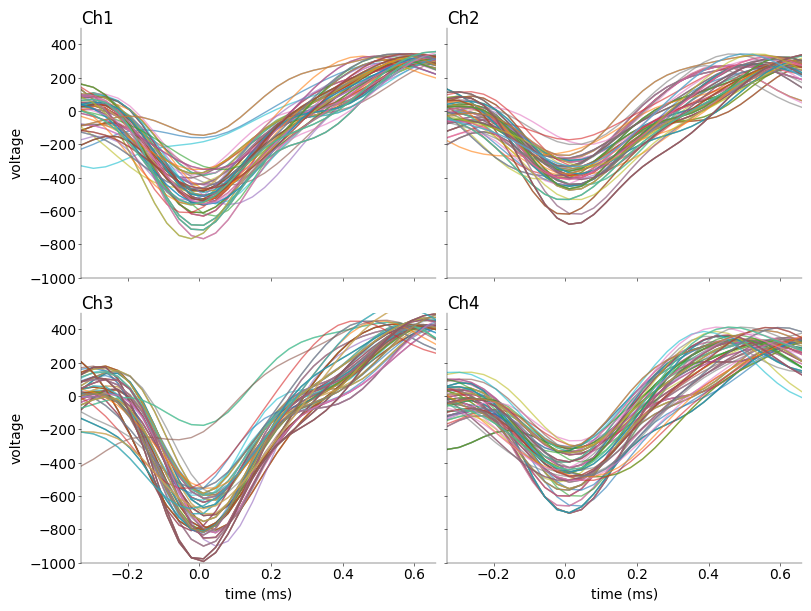

In [14]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------------
# plot the largest 100 spikes (0.5 pts)
# -------------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    # extract the 100 largest spikes from channel i
    # this returns the indices of the 100 largest spikes
    largest_spikes = np.argsort(np.max(waveforms[:, :, i], axis=1))[-100:]

    for j in largest_spikes:  # TODO for loop is ugly
        ax[col].plot(np.linspace(-0.33, 0.66, 30), waveforms[j, :, i], alpha=0.6)

    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### PCA:
- how to preprocess data?


(https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)

In [15]:
def extract_features(w: np.ndarray):
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # insert your code here

    # ---------------------------------------------
    # obtain first 3 principle components (2 pts)
    # ---------------------------------------------

    pca = PCA(n_components=3)

    b = np.concatenate(
        [pca.fit_transform(w[:, :, i]) for i in range(w.shape[2])], axis=1
    )
    print("b.shape: {}".format(b.shape))
    # print("b[5]: {}".format(b[5]))

    # -----------------------------------------------------
    # Print the fraction of variance explained (1 pt)
    # -----------------------------------------------------
    print("explained variance: {}".format(pca.explained_variance_))

    return b


from sklearn.preprocessing import normalize

waveforms_norm = np.zeros(waveforms.shape)
for i in range(waveforms.shape[2]):
    # normalize each channel
    waveforms_norm[:, :, i] = normalize(waveforms[:, :, i])
features = extract_features(waveforms_norm)
features = extract_features(waveforms)

b.shape: (30483, 12)
explained variance: [0.05089436 0.02423982 0.02053248]
b.shape: (30483, 12)
explained variance: [63464.08456741 29061.4449007  12418.57636761]


Text(0.5, 0.98, 'Pairwise 1st PCs')

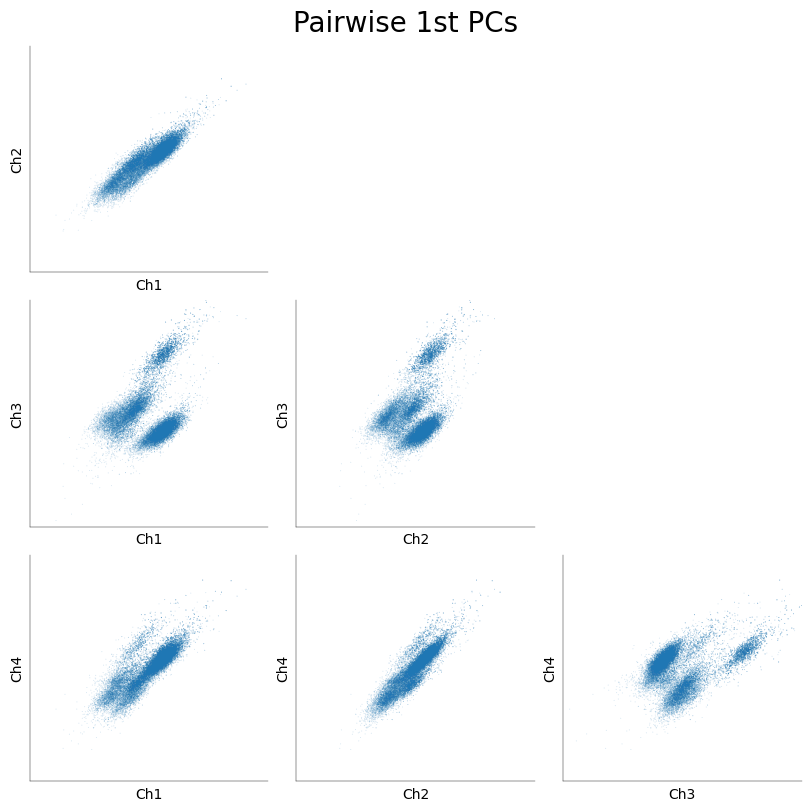

In [24]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    yb, xb = m.split(" vs ")

    # plot the 1st PC of channel y against the 1st PC of channel x
    ax[m].scatter(
        features[:, i[xb]], features[:, i[yb]], alpha=0.2, s=2, edgecolors="none"
    )

    ax[m].set_xlabel(xb)
    ax[m].set_ylabel(yb)
    ax[m].set_xlim((-1500, 1500))
    ax[m].set_ylim((-1500, 1500))
    ax[m].set_xticks([])
    ax[m].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

We can see some clusters visually. By tweaking the threshold the clusters become more explicit. I.e. setting the threshold-multiplier N to 7 results in clear clusters between Ch3 and Ch2, Ch4 and Ch3 and of course Ch1 and Ch3.

In [ ]:
# # save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)